In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import set_random_seed
set_random_seed(1)
plt.rcParams["figure.figsize"] = (12,7)
sns.set_style("darkgrid")

In [11]:
df = pd.read_csv("data/space_embedding_data.csv", index_col=[0])
df.head()

,Grid,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,...,Health_rating,Other_rating,Outdoors_rating,Restaurant_rating,Retail_rating,Service_rating,Wholesale_rating,PositiveReviews,NegativeReviews,ReviewLength
0,L0,8,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.020000,0.0,3.942857,0.000000,0.000000,0.000000,0.696000,0.304000,0.536595
1,L1,10,0,1,0,0.0,0.0,1.0,0.0,0.0,...,5.0,0.000000,0.0,4.777778,0.000000,4.000000,0.000000,0.851852,0.148148,0.802238
2,L10,3,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.999095
3,L100,74,2,9,6,12.0,6.0,6.0,0.0,1.0,...,3.6,4.024460,0.0,3.711172,4.500000,3.028846,0.000000,0.732975,0.267025,0.895548
4,L101,163,7,31,5,21.0,19.0,20.0,1.0,1.0,...,4.5,4.223132,0.0,3.748855,3.549446,4.311111,3.722222,0.801535,0.198465,0.843739


In [12]:
y = df[[i for i in df.columns if "_rating" not in i]].drop(["Grid"], axis=1)
X = pd.get_dummies(df.Grid).values

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y_tf = sc.fit_transform(y)

# Space Embeddings model

## Continuous features

In [15]:
from keras.models import Model
from keras.layers import Dense, Embedding, Flatten
from keras import Input
# Parameters
input_neurons = X.shape[0]
output_neurons = y_tf.shape[1]

# Model architecture
inp = Input(shape=(input_neurons,))
emb = Embedding(input_dim=input_neurons, output_dim=8, input_length=input_neurons)(inp)
flat = Flatten()(emb)

dict_losses = {}
output_acts = []
for idx in range(len(y.columns)):
    output_act = Dense(1, activation="linear", use_bias=True, name="output_layer_cont" + str(idx))(flat)
    output_acts.append(output_act)
    dict_losses['output_layer_cont' + str(idx)] = 'mean_squared_error'

model = Model(inputs=inp, outputs=output_acts)

In [16]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 480)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 480, 8)       3840        ['input_3[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 3840)         0           ['embedding_2[0][0]']            
                                                                                                  
 output_layer_cont0 (Dense)     (None, 1)            3841        ['flatten_2[0][0]']              
                                                                                            

In [17]:
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

In [18]:
from tensorflow.keras.optimizers import Adam
import json

opt = Adam(learning_rate=0.01)
model.compile(loss=dict_losses, optimizer=opt)

batch_size = 64
epochs = 10
history = model.fit(X, y_tf, batch_size=batch_size, epochs=epochs, verbose=3)

# save weights
### Vi kom hertil

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


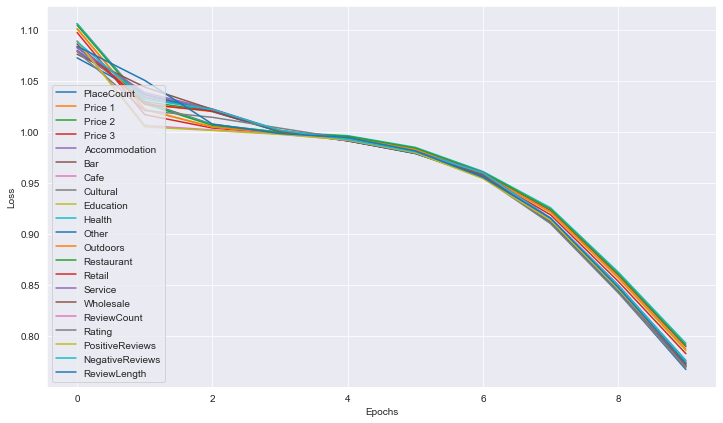

In [19]:
for idx, (key, value) in enumerate(history.history.items()):
    if key != "loss":
        plt.plot(history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

In [22]:
from sklearn.metrics import mean_squared_error
continuous_model = []
y_pred = model.predict(X)
y_pred = np.array(y_pred).T.squeeze()
for i in range(y_pred.shape[1]):
    mse_feature = mean_squared_error(y_tf[:, i], y_pred[:, i])
    print(y.columns[i], "MSE:", mse_feature)
    continuous_model.append(mse_feature)

PlaceCount MSE: 0.5158296184216273
Price 1 MSE: 0.6053913441832303
Price 2 MSE: 0.5605448137202652
Price 3 MSE: 0.6136232589303177
Accommodation MSE: 0.785351683427119
Bar MSE: 0.639752994202888
Cafe MSE: 0.5928635385141218
Cultural MSE: 0.6312134903970802
Education MSE: 0.7214709751730469
Health MSE: 0.688156729915515
Other MSE: 0.5760703292836294
Outdoors MSE: 0.8016936628355907
Restaurant MSE: 0.5878709186710658
Retail MSE: 0.5773882011314051
Service MSE: 0.5723315442470631
Wholesale MSE: 0.6362121973938791
ReviewCount MSE: 0.5600393575849996
Rating MSE: 1.0914592634859455
PositiveReviews MSE: 1.0288070904738058
NegativeReviews MSE: 1.1433923145608977
ReviewLength MSE: 1.0198575250944832


## Discrete/categorical features

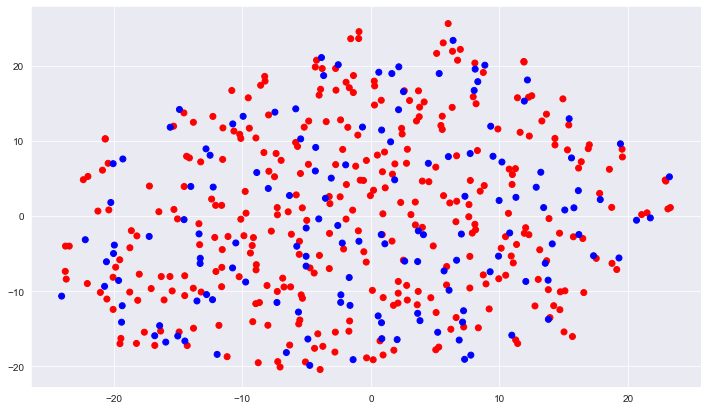

In [21]:
from sklearn.manifold import TSNE
embeddings = model.layers[1].get_weights()[0]
colors = (df.Grid.str.startswith("L")*1).values
colors = ["red" if i==1 else "blue" for i in colors]
X_emb = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(embeddings)

plt.figure(figsize=(12,7))
plt.scatter(X_emb[:, 0], X_emb[:, 1], color=colors);

## Optimization

https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [10]:
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [11]:
# Create function
# https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
def optimize(neurons, activation, learning_rate,  batch_size, epochs):

    activationL = ['relu', 'sigmoid', 'tanh', 'exponential']

    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    

    def build_nn():
        nn = Sequential()
        nn.add(Input(shape=(input_neurons,)))
        nn.add(Dense(hidden_neurons, activation=activation))
        nn.add(Dense(output_neurons, activation='relu'))

        opt = Adam(lr = learning_rate)
        nn.compile(loss="mean_squared_error", optimizer=opt, metrics=["mean_squared_error"])
        
        return nn


    es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=False, patience=20)

    nn = KerasRegressor(build_fn=build_nn, epochs=epochs, batch_size=batch_size,
                         verbose=False)

    kfold = KFold(n_splits=5, shuffle=True, random_state=123)

    score = cross_val_score(nn, X, y_tf, scoring='neg_mean_squared_error', cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [12]:
params_nn ={
    'neurons': (600, 1000),
    'activation':(0, 3),
    'learning_rate':(0.01, 1),
    'batch_size':(1, 20),
    'epochs':(100, 300)
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(optimize, params_nn, random_state=123)
nn_bo.maximize(init_points=5, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  |
-------------------------------------------------------------------------------------
|  1        | -1.0      |  2.089    |  6.437    |  145.4    |  0.5558   |  887.8    |
|  2        | -1.0      |  1.269    |  19.63    |  237.0    |  0.4861   |  756.8    |
|  3        | -1.0      |  1.03     |  14.85    |  187.7    |  0.06908  |  759.2    |
|  4        | -1.0      |  2.214    |  4.467    |  135.1    |  0.5362   |  812.7    |
|  5        | -1.0      |  1.903    |  17.14    |  244.9    |  0.6149   |  889.0    |
|  6        | -1.0      |  2.44     |  4.719    |  104.6    |  0.7045   |  601.1    |
|  7        | -1.0      |  2.344    |  14.06    |  296.0    |  0.2775   |  603.4    |
|  8        |  nan      |  2.638    |  3.555    |  297.8    |  0.7587   |  999.8    |


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**Implement categorical features that have uniformly distributed classes**

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei